# Necessary module import

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import h5py
import pandas as pd
import ast
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchinfo import summary
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from DatasetPreprocessing import GEOSFiveYearDatasetSimple
from runet_3d import model
from plots_3d_helper import *

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Input data construction

In [4]:
## Geomodel description, permx, permz, poro
nt, nx, ny, nz = 11, 35, 35, 11

geomodel = {}
kxy = np.genfromtxt('Geomodel_base/tables/permTable').reshape((nx, ny, nz)) * 1.01324997e+15 # conversion from m^2 to mD
kz = np.genfromtxt('Geomodel_base/tables/permZTable').reshape((nx, ny, nz)) * 1.01324997e+15 
phi = np.genfromtxt('Geomodel_base/tables/poroTable').reshape((nx, ny, nz))

kxy = (kxy - kxy.min()) / (kxy.max() - kxy.min() + 1e-8)
kz  = (kz  - kz.min())  / (kz.max() - kz.min() + 1e-8)
phi = (phi - phi.min()) / (phi.max() - phi.min() + 1e-8)

geomodel["permxy"] = kxy
geomodel["permz"] = kz
geomodel["phi"] = phi

In [5]:
# metadata for well locations and well rates
meta = pd.read_csv('dataset_3/run_log.csv', index_col='run_id')
meta['well_coords'] = (meta['well_coords'].apply(ast.literal_eval))
meta['rate_matrix'] = meta['rate_matrix'].apply(ast.literal_eval)
meta['rate_matrix'] = meta['rate_matrix'].apply(lambda x: np.array(x, dtype=float))

def map_coord_to_index(x, x_max=11200, n=35):
    #return int(np.clip(round((x / x_max) * (n - 1)), 0, n - 1))
    return int(round((x / x_max) * (n - 1)))

meta['well_coords'] = meta['well_coords'].apply(
    lambda wells: [(map_coord_to_index(x), map_coord_to_index(y)) for (x, y) in wells]
)

In [6]:
splits = np.load('split_ids.npz')
train_ids, dev_ids, test_ids = splits['train'], splits['dev'], splits['test']

In [7]:
h5path = ['h5_outputs/Training_data_1.h5', 'h5_outputs/Training_data_2.h5']

In [8]:
# Determine the overall P_sigma and P_mu
P_list, S_list = [], []
for p in h5path:
    with h5py.File(p, 'r') as hf:
        P_list.append(hf['pressure'][...])    # (n, Nt, 35, 35, 11)
        S_list.append(hf['saturation'][...])  # (n, Nt, 35, 35, 11)
P_all = np.concatenate(P_list, axis=0)
S_all = np.concatenate(S_list, axis=0)

P_MU, P_SIGMA = float(P_all.mean()), float(P_all.std() + 1e-8)

In [9]:
meta_train = meta.loc[train_ids]
meta_dev   = meta.loc[dev_ids]
meta_test  = meta.loc[test_ids]

In [10]:
train_dataset = GEOSFiveYearDatasetSimple(h5path, meta_train, geomodel, P_MU, P_SIGMA)
dev_dataset   = GEOSFiveYearDatasetSimple(h5path, meta_dev, geomodel, P_MU=P_MU, P_SIGMA=P_SIGMA)
test_dataset  = GEOSFiveYearDatasetSimple(h5path, meta_test, geomodel, P_MU=P_MU, P_SIGMA=P_SIGMA)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=10, shuffle=False)

In [12]:
# load a pretrained model.
# If you run this cell, please skip to the evaluation section
model.load_state_dict(torch.load('best_resunet3d_14.pt'))

<All keys matched successfully>

In [13]:
summary(model,input_size=(1,4, 35, 35, 11), device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
ResUNet3D                                [1, 2, 35, 35, 11]        --
├─ResBlock3D: 1-1                        [1, 32, 35, 35, 11]       --
│    └─Conv3d: 2-1                       [1, 32, 35, 35, 11]       128
│    └─Conv3d: 2-2                       [1, 32, 35, 35, 11]       3,456
│    └─BatchNorm3d: 2-3                  [1, 32, 35, 35, 11]       64
│    └─ReLU: 2-4                         [1, 32, 35, 35, 11]       --
│    └─Conv3d: 2-5                       [1, 32, 35, 35, 11]       27,648
│    └─BatchNorm3d: 2-6                  [1, 32, 35, 35, 11]       64
│    └─ReLU: 2-7                         [1, 32, 35, 35, 11]       --
├─DownBlock3D: 1-2                       [1, 64, 18, 18, 6]        --
│    └─Conv3d: 2-8                       [1, 64, 18, 18, 6]        55,360
│    └─ResBlock3D: 2-9                   [1, 64, 18, 18, 6]        --
│    │    └─Identity: 3-1                [1, 64, 18, 18, 6]        --
│  

In [ ]:
# ---------------------------
# Loss function
# ---------------------------
def loss_fn(pred, target, lambda_s=1.0, plume_tau=0.02, plume_w=10):
    """
    pred, target: tensors of shape (B, 2, 35, 35, 11)
    lambda_s: weighting factor for saturation term
    """
    # Split into pressure and saturation channels
    P_pred, S_pred = pred[:, 0], pred[:, 1]
    P_true, S_true = target[:, 0], target[:, 1]
    
    # L1 loss for each field
    loss_p = F.mse_loss(P_pred, P_true)
    #loss_s = F.mse_loss(S_pred, S_true)
    w = torch.ones_like(S_true)
    w = torch.where(S_true > plume_tau, torch.full_like(w, plume_w), w)
    loss_s = (w * (S_pred - S_true)**2).mean()
    
    
    total_loss = loss_p + lambda_s * loss_s 
    return total_loss, loss_p.item(), loss_s.item()


In [ ]:
# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=5,
                                                 verbose=True)

In [ ]:
# Track metrics across epochs
train_total_hist, val_total_hist = [], []
train_p_hist, train_s_hist = [], []
val_p_hist, val_s_hist = [], []

# ---------------------------
# Configuration
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 200
lambda_s = 1.0      # weight for saturation term
log_interval = 4000   # print every N batches

# Move model to GPU/CPU
model = model.to(device)

# ---------------------------
# Training and validation loops
# ---------------------------
def train_one_epoch(model, dataloader, optimizer, lambda_s=1.0):
    model.train()
    running_loss, running_p, running_s = 0.0, 0.0, 0.0

    for batch_idx, (X, Y) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        X, Y = X.to(device), Y.to(device)

        # Forward
        pred = model(X)
        loss, loss_p, loss_s = loss_fn(pred, Y, lambda_s=lambda_s)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
        optimizer.step()

        running_loss += loss.item()
        running_p += loss_p
        running_s += loss_s

        if (batch_idx + 1) % log_interval == 0:
            print(f"  [Batch {batch_idx+1}/{len(dataloader)}] "
                  f"Loss: {loss.item():.4f} | L_P: {loss_p:.4f} | L_S: {loss_s:.4f}")

    n = len(dataloader)
    return running_loss / n, running_p / n, running_s / n


@torch.no_grad()
def evaluate(model, dataloader, lambda_s=1.0):
    model.eval()
    total_loss, total_p, total_s = 0.0, 0.0, 0.0

    for X, Y in tqdm(dataloader, desc="Validation", leave=False):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss, loss_p, loss_s = loss_fn(pred, Y, lambda_s=lambda_s)
        total_loss += loss.item()
        total_p += loss_p
        total_s += loss_s

    n = len(dataloader)
    return total_loss / n, total_p / n, total_s / n


# ---------------------------
# Main training loop
# ---------------------------
best_val_loss = float('inf')

start_time = time.time()
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    train_loss, train_p, train_s = train_one_epoch(model, train_loader, optimizer, lambda_s)
    torch.cuda.empty_cache()
    val_loss, val_p, val_s = evaluate(model, dev_loader, lambda_s)
    torch.cuda.empty_cache()

    print(f"  Train: L={train_loss:.6f} | L_P={train_p:.6f} | L_S={train_s:.6f}")
    print(f"  Valid: L={val_loss:.6f} | L_P={val_p:.6f} | L_S={val_s:.6f}")

    # Record history
    train_total_hist.append(train_loss)
    val_total_hist.append(val_loss)
    train_p_hist.append(train_p)
    train_s_hist.append(train_s)
    val_p_hist.append(val_p)
    val_s_hist.append(val_s)

    if 'scheduler' in locals():
        scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_resunet3d_13.pt")
        print("Saved new best model")

end_time = time.time()
training_time = end_time - start_time
print("Training time: %.4f" %(training_time))
print("\nTraining complete. Best validation loss:", best_val_loss)

In [ ]:
epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Primary y-axis: total + pressure losses ---
ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Total Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 , labels_1 , loc='upper right')

# plt.title("Training and Validation Losses")
plt.tight_layout()
plt.savefig('train_val loss.png', dpi=600)
plt.show()

epochs = range(1, len(train_total_hist) + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

# --- Primary y-axis: total + pressure losses ---
ax1.plot(epochs, train_total_hist, 'b-', label='Train Total Loss')
ax1.plot(epochs, val_total_hist, 'r--', label='Validation Total Loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Total Loss")
ax1.tick_params(axis='y', labelcolor='k')
#plt.ylim([0,1])
plt.yscale('log')

# --- Combined legend ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 , labels_1 , loc='upper right')


# plt.title("Training and Validation Losses")
plt.tight_layout()
plt.savefig('train_val loss.png', dpi=600)
plt.show()

## Test set Evaluation

In [14]:
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [15]:
start_time = time.time()
model.eval()
preds_P, preds_S = [], []
truth_P, truth_S = [], []

with torch.no_grad():
    for X, Y in tqdm(test_loader, desc="Evaluating on test set"):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)

        P_pred, S_pred = pred[:, 0].cpu().numpy(), pred[:, 1].cpu().numpy()
        P_true, S_true = Y[:, 0].cpu().numpy(), Y[:, 1].cpu().numpy()

        preds_P.append(P_pred)
        preds_S.append(S_pred)
        truth_P.append(P_true)
        truth_S.append(S_true)

end_time = time.time()
test_time = end_time - start_time
print("Test time: %.4f" %(test_time))
# concatenate along batch dimension
preds_P = np.concatenate(preds_P, axis=0)
preds_S = np.concatenate(preds_S, axis=0)
truth_P = np.concatenate(truth_P, axis=0)
truth_S = np.concatenate(truth_S, axis=0)

Evaluating on test set: 100%|████████████████████████████████████| 100/100 [00:00<00:00, 122.56it/s]

Test time: 0.8177


In [16]:
def rollout_one_run(model, dataset, run_number, device):
    """
    Autoregressive rollout on a single GEOS run in test_dataset.

    run_number: integer 0 .. (num_runs-1)
    """
    model.eval()
    Nt = dataset.Nt          # 11
    steps = Nt - 1           # 10

    # compute the correct dataset index range
    base_idx = run_number * steps

    preds = []
    trues = []

    with torch.no_grad():

        # --- first step: use dataset's true initial state ---
        X_k, Y_true = dataset[base_idx]   # guaranteed to be the first transition of this run
        X_k = X_k.clone()

        X_t = X_k.unsqueeze(0).to(device)
        Y_true_t = Y_true.unsqueeze(0).to(device)

        Y_pred_t = model(X_t)

        preds.append(Y_pred_t.squeeze(0).cpu().numpy())
        trues.append(Y_true_t.squeeze(0).cpu().numpy())

        # next input state = predicted output
        P_next = Y_pred_t[0,0].cpu()
        S_next = Y_pred_t[0,1].cpu()

        # --- subsequent 9 steps ---
        for k in range(1, steps):
            idx = base_idx + k

            X_k, Y_true = dataset[idx]
            X_k = X_k.clone()

            # replace channels 0 and 1 with predicted P,S
            X_k[0] = P_next
            X_k[1] = S_next

            X_t = X_k.unsqueeze(0).to(device)
            Y_true_t = Y_true.unsqueeze(0).to(device)

            Y_pred_t = model(X_t)

            preds.append(Y_pred_t.squeeze(0).cpu().numpy())
            trues.append(Y_true_t.squeeze(0).cpu().numpy())

            P_next = Y_pred_t[0,0].cpu()
            S_next = Y_pred_t[0,1].cpu()

    preds = np.stack(preds)
    trues = np.stack(trues)
    return preds, trues

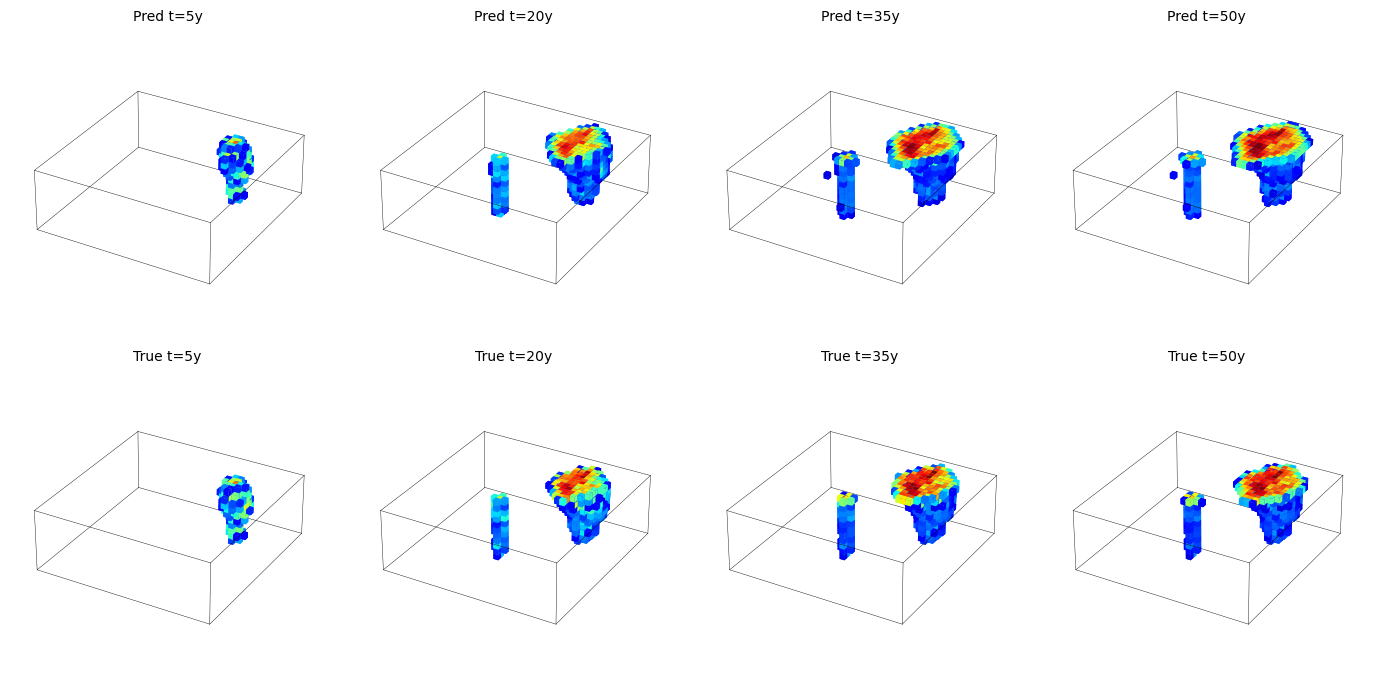

In [17]:
timesteps_to_plot = [0, 3, 6, 9]
run_number = 6     # example run
pred_seq, true_seq = rollout_one_run(model, test_dataset, run_number, device)

compare_rollout_8panel(pred_seq, true_seq, timesteps_to_plot,
                       savefig="rollout_comparison_run3.png")